# Baseline 2:

Staged Least Squares Instrumental Variables Regression using Cornelia's Medical Data

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

---
### Step 1: Import packages

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.stats.anova import anova_lm

import patsy
import sklearn.preprocessing as sklp
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

---
### Step 2: Define working directories and global variables

#### 2.1. Set working directories

In [2]:
# in_dir_sc = 'C:/Users/cilin/Research/CA_hospitals_capstone/data/'
# in_dir_h = 'C:/Users/cilin/Research/CA_hospitals_capstone/output/'
# out_dir = 'C:/Users/cilin/Research/CA_hospitals_capstone/models/'


in_dir_sc = '/Users/michelle/MIDS/210 Capstone/data/'
in_dir_h = '/Users/michelle/MIDS/210 Capstone/output/'
out_dir1 = '/Users/michelle/MIDS/210 Capstone/models_s1/'
out_dir2 = '/Users/michelle/MIDS/210 Capstone/models_s2/'

#### 2.2. Define fixed effects

In [3]:

fixed_effects = " ~ county + month + year_trend * C(county_month)"

---
### Step 3: Define functions

In [4]:
def fit_ols(df, outcome, predictor):
    ''''''
    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # create FE and interactions between FE and continous vars
    f = outcome + " ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    # X = temp[['pm25']]
    X = temp[[predictor]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(model_a.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))

In [5]:
def fit_1st_stage(df, pm_col, instr_col, fixed_effects):
    ''' First stage to check whether wfeI is a strong instrument for pm25I
    '''
    
    temp = df.copy()

    # create FE and interactions between FE and continous vars
    f = pm_col + fixed_effects
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    X = temp[[instr_col]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    fit_1st_stage = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', pm_col)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(fit_1st_stage.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            fit_1st_stage.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))
    
    # save pm25I_hat
    temp[pm_col+'_hat'] = fit_1st_stage.get_prediction(X).summary_frame()['mean']
    
    # save model
    results_label = "s1_PREDICTOR_" + instr_col + "_TARGETING_" + pm_col + "_LAG_" + HO_lag_input + ".pkl"
    filename = os.path.join(out_dir1, results_label)
    fit_1st_stage.save(filename, remove_data=True)

    
    # stage 2 dataset to save off:
    # year_month, school_zip, predicted pm2.5 predictor, FE columns, predicted health outcome

    return temp

In [6]:
def fit_2sls(df, outcome, independent_var_name, fixed_effects):
    ''''''
    #independent_var_name example: 'pm25_hat'

    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # create FE and interactions between FE and continous vars
    f = outcome + fixed_effects #" ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    #X = temp[['pm25_hat']]
    X = temp[[independent_var_name]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(model_a.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))

    # save model
    results_label = "s2_PREDICTOR_" + independent_var_name + "_TARGETING_" + outcome + ".pkl"
    filename = os.path.join(out_dir2, results_label)
    model_a.save(filename, remove_data=True)

---
### Step 4: Read and clean data

#### 4.1. Function to generate rolling windows on dataframe (lead)

In [7]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed']
    ,rolling_periods:list = [6]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month'])
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = rolling_periods

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int



#### 4.2. Read in non-medical data and medical data
* Generate rolling windows for non-medical data for instrumental variable
* Filter out 2018 data from both non-medica and medical data

In [8]:
# non-medical data
for file in os.listdir(in_dir_sc):
    if file.startswith('modeling'):
        # read in our modeling data
        df_sc = pd.read_csv(os.path.join(in_dir_sc, file))

# add key to df
df_sc['patzip_year_month'] = df_sc.school_zip.astype(str) + '-' + df_sc.year.astype(str) + '-' + df_sc.month.astype(str)

# add instrumental variables rolling things here - looking at past data, so need 2000-2002 for previous avgs
cols_to_roll = ['Izmy_v1_unnormed',
'Izmy_v2_nodist_unnormed',
'Izmy_v3_normed_D_and_TPY',
'Izmy_v4_nodist_normed_TPY',
'Izmy_v5_all_normed',
'central_wind_alignment_180_high']

rolling_periods = [1, 6, 9, 12]
df_sc, all_cols = roll_selected_cols(df=df_sc, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

# drop if year >=2018
df_sc = df_sc[df_sc.year.le(2017)]

# print shape of data
print('Shape of data ', df_sc.shape)
df_sc.head(2)



Shape of data  (294897, 171)


,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,patzip_year_month,Izmy_v1_unnormed_r1,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v1_unnormed_r12,Izmy_v2_nodist_unnormed_r1,Izmy_v2_nodist_unnormed_r6,Izmy_v2_nodist_unnormed_r9,Izmy_v2_nodist_unnormed_r12,Izmy_v3_normed_D_and_TPY_r1,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v3_normed_D_and_TPY_r12,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,Izmy_v5_all_normed_r1,Izmy_v5_all_normed_r6,Izmy_v5_all_normed_r9,Izmy_v5_all_normed_r12,central_wind_alignment_180_high_r1,central_wind_alignment_180_high_r6,central_wind_alignment_180_high_r9,central_wind_alignment_180_high_r12
0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,0.757031,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667

In [9]:
# medical data
df_h = pd.DataFrame()
df_h['patzip_year_month'] = df_sc.patzip_year_month.unique()

for file in os.listdir(in_dir_h):
    # read in cornelia's healthcare data
    temp = pd.read_csv(os.path.join(in_dir_h, file)).iloc[:,1:]
    # rename number_of_visits column
    temp.rename(
        columns={'number_of_visits':'visits_'+file.split('.')[0]},
        inplace=True
    )

    # merge to df_h
    df_h = df_h.merge(
        temp[['patzip_year_month', 'visits_'+file.split('.')[0]]],
        on='patzip_year_month',
        how='left'
    )

# Filter out 2018 data bc it's all nulls 
# if year > 2017, drop
df_h['year_h'] = df_h.patzip_year_month.str.split('-').str[1]
df_h = df_h[df_h.year_h.le('2017')]
df_h.drop(columns='year_h', inplace=True)

# print shape of data
print('Shape of data ', df_h.shape)
df_h[~df_h.visits_resp_cardio.isna()].head(2)

Shape of data  (294897, 6)


,patzip_year_month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio
35905,91214-2000-5,NaN,NaN,NaN,NaN,112.0
35906,91214-2000-6,NaN,NaN,NaN,NaN,112.0


In [10]:
df_h.columns

Index(['patzip_year_month', 'visits_hematopoietic_cancers',
       'visits_injuries_accidents', 'visits_type_1_diabetes',
       'visits_pediatric_vasculitis', 'visits_resp_cardio'],
      dtype='object')

---
### Step 5: Data preprocessing

#### 5.1. Merge non-medical and medical datasets

In [11]:
# merge df_h to df_sc
df_all = df_sc.merge(
    df_h,
    on='patzip_year_month',
    how='left'
)

# print shape of data
print('Shape of data ', df_all.shape)
df_all.head(2)

# Shape of data  (294897, 164) <-- old one

Shape of data  (294897, 176)


,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,patzip_year_month,Izmy_v1_unnormed_r1,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v1_unnormed_r12,Izmy_v2_nodist_unnormed_r1,Izmy_v2_nodist_unnormed_r6,Izmy_v2_nodist_unnormed_r9,Izmy_v2_nodist_unnormed_r12,Izmy_v3_normed_D_and_TPY_r1,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v3_normed_D_and_TPY_r12,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,Izmy_v5_all_normed_r1,Izmy_v5_all_normed_r6,Izmy_v5_all_normed_r9,Izmy_v5_all_normed_r12,central_wind_alignment_180_high_r1,central_wind_alignment_180_high_r6,central_wind_alignment_180_high_r9,central_wind_alignment_180_high_r12,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio
0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321

#### 5.2. Fill in nulls conditionally on merged datasets

* the problem: for each health outcome, we want to fill in the nulls for a zipcode with 0's only if that row occurred after the first non-zero/not null visit in that zipcode for that health outcome. Keep them as nulls otherwise.
* So basically a zipcode will keep the nulls if they're on a date before the first visit seen for that health outcome, nulls will become 0 after the first visit seen for that health outcome.

In [12]:
def filter_nans(df, visits_cols = ['visits_hematopoietic_cancers', 'visits_injuries_accidents',
       'visits_type_1_diabetes', 'visits_pediatric_vasculitis',
       'visits_resp_cardio']):
    """Function to generate columns in place that replace NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # check the school zip first
        if dataset_row_idx < first_val_row_idx:
            orig_visits = orig_visits
        elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
            if pd.isnull(orig_visits):
                orig_visits = 0
            else:
                orig_visits = orig_visits
        return orig_visits
        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    #df_grouped_schools['points_rank'] = df.groupby(['team'])['points'].rank('dense', ascending=False)
    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]
            #display(temp)
            #temp['rowIndex'] = temp.apply(get_rowIndex, axis=1)
            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            #display(visits_series)
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set valye to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

# call function:
df_all = filter_nans(df_all, visits_cols = ['visits_hematopoietic_cancers', 'visits_injuries_accidents', 'visits_type_1_diabetes', 'visits_pediatric_vasculitis', 'visits_resp_cardio'])
display(df_all)


,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,patzip_year_month,Izmy_v1_unnormed_r1,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v1_unnormed_r12,Izmy_v2_nodist_unnormed_r1,Izmy_v2_nodist_unnormed_r6,Izmy_v2_nodist_unnormed_r9,Izmy_v2_nodist_unnormed_r12,Izmy_v3_normed_D_and_TPY_r1,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v3_normed_D_and_TPY_r12,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,Izmy_v5_all_normed_r1,Izmy_v5_all_normed_r6,Izmy_v5_all_normed_r9,Izmy_v5_all_normed_r12,central_wind_alignment_180_high_r1,central_wind_alignment_180_high_r6,central_wind_alignment_180_high_r9,central_wind_alignment_180_high_r12,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio
0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321

#### 5.3. Create response variables

In [13]:
# Create response variables, which is visits / population
for col in df_h.columns[1:]:
    df_all['y_'+col] = 1000 * df_all[col] / df_all['total_pop_under19']
    
# add year trend
year_map = {label: idx for idx, label in enumerate(np.sort(df_all.year.unique()))}
df_all["year_trend"] = df_all.year.map(year_map)
df_all["year_trend"] = df_all.year_trend + 1

# create county_month 
df_all['county_month'] = df_all.school_county_v2 + '_' + df_all.month.astype(str)

# rename school_county_v2
df_all.rename(columns={'school_county_v2': 'county'}, inplace=True)

# reset index
df_all.reset_index(drop=True, inplace=True)

# print shape of data
print('Shape of data ', df_all.shape) # Old shape of data  (294897, 174)
df_all.head(2)

Shape of data  (294897, 183)


,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,patzip_year_month,Izmy_v1_unnormed_r1,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v1_unnormed_r12,Izmy_v2_nodist_unnormed_r1,Izmy_v2_nodist_unnormed_r6,Izmy_v2_nodist_unnormed_r9,Izmy_v2_nodist_unnormed_r12,Izmy_v3_normed_D_and_TPY_r1,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v3_normed_D_and_TPY_r12,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,Izmy_v5_all_normed_r1,Izmy_v5_all_normed_r6,Izmy_v5_all_normed_r9,Izmy_v5_all_normed_r12,central_wind_alignment_180_high_r1,central_wind_alignment_180_high_r6,central_wind_alignment_180_high_r9,central_wind_alignment_180_high_r12,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_type_1_diabetes,y_visits_pediatric_vasculitis,y_visits_resp_cardio,year_trend,county_month
0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3

#### 5.4. Generate rolling windows on Health Outcomes (lag)

In [14]:
# get rolling n month sum

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month'])
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 

In [15]:
df_all = df_all.sort_values(['school_zip', 'year_month'])
starting_cols = list(df_all.columns)

num_visits_col_names = ['visits_hematopoietic_cancers', 'visits_injuries_accidents', 'visits_type_1_diabetes', 'visits_pediatric_vasculitis', 'visits_resp_cardio']

y_col_names = ['y_visits_hematopoietic_cancers', 'y_visits_injuries_accidents', 'y_visits_type_1_diabetes', 'y_visits_pediatric_vasculitis', 'y_visits_resp_cardio']

# 3 months ---
n = 3 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']

# print columns added
ending_cols = list(df_all.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 3 month window:\n{window_3months_columns}")
starting_cols = list(df_all.columns)

# 6 months ---
n = 6 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']


# print columns added
ending_cols = list(df_all.columns)
window_6months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 6 month window:\n{window_6months_columns}")
starting_cols = list(df_all.columns)


# 12 months ---
n = 12

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']


ending_cols = list(df_all.columns)
window_12months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 12 month window:\n{window_12months_columns}")
starting_cols = list(df_all.columns)


Columns added for health outcomes using 3 month window:
['visits_hematopoietic_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'visits_hematopoietic_cancers_cent3', 'y_visits_hematopoietic_cancers_cent3', 'visits_injuries_accidents_fwd3', 'y_visits_injuries_accidents_fwd3', 'visits_injuries_accidents_cent3', 'y_visits_injuries_accidents_cent3', 'visits_type_1_diabetes_fwd3', 'y_visits_type_1_diabetes_fwd3', 'visits_type_1_diabetes_cent3', 'y_visits_type_1_diabetes_cent3', 'visits_pediatric_vasculitis_fwd3', 'y_visits_pediatric_vasculitis_fwd3', 'visits_pediatric_vasculitis_cent3', 'y_visits_pediatric_vasculitis_cent3', 'visits_resp_cardio_fwd3', 'y_visits_resp_cardio_fwd3', 'visits_resp_cardio_cent3', 'y_visits_resp_cardio_cent3']

Columns added for health outcomes using 6 month window:
['visits_hematopoietic_cancers_fwd6', 'y_visits_hematopoietic_cancers_fwd6', 'visits_hematopoietic_cancers_cent6', 'y_visits_hematopoietic_cancers_cent6', 'visits_injuries_accidents_fwd6', 'y_vis

#### 5.5. Filter out 2018 Data

In [16]:
#filter data to appropriate data range
df_all = df_all[df_all.year >= 2002]

print(min(df_all.year))
print(max(df_all.year))

2002
2017


In [17]:
df_all.head()

,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,patzip_year_month,Izmy_v1_unnormed_r1,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v1_unnormed_r12,Izmy_v2_nodist_unnormed_r1,Izmy_v2_nodist_unnormed_r6,Izmy_v2_nodist_unnormed_r9,Izmy_v2_nodist_unnormed_r12,Izmy_v3_normed_D_and_TPY_r1,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v3_normed_D_and_TPY_r12,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,Izmy_v5_all_normed_r1,Izmy_v5_all_normed_r6,Izmy_v5_all_normed_r9,Izmy_v5_all_normed_r12,central_wind_alignment_180_high_r1,central_wind_alignment_180_high_r6,central_wind_alignment_180_high_r9,central_wind_alignment_180_high_r12,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_type_1_diabetes,y_visits_pediatric_vasculitis,y_visits_resp_cardio,year_trend,county_month,visits_hematopoietic_cancers_fwd3,y_visits_hematopoietic_cancers_fwd3,visits_hematopoietic_cancers_cent3,y_visits_hema

#### 5.6. Specify which inputs and outputs we're looking at

In [18]:
predictor = 'Izmy_v1_unnormed'
lead_time = '6'
lag_time = '3'
lag_style = 'fwd'

# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag 
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col # columns to filter out at the beginning and end of df, before modeling

target_name_s1 = f'pm25{IV_lead_input}'
predictor_name_s1 = f'{predictor}{IV_lead_input}'

print(f"Stage 1\nTarget Name (target_name_s1) = {target_name_s1}\nPredictor Name (predictor_name_s1) = {predictor_name_s1}")

print(f"\nStage 2\nHealth Outcome Lag Input (HO_lag_input) = {HO_lag_input}")

Stage 1
Target Name (target_name_s1) = pm25_r6
Predictor Name (predictor_name_s1) = Izmy_v1_unnormed_r6

Stage 2
Health Outcome Lag Input (HO_lag_input) = _fwd3


#### 5.7. Filter out the nulls in inputs

In [19]:
# print out all nulls in dataset
temp = df_all.isna().sum()
temp[temp > 0]


pm25_last_month                             24
pm25_r6                                    146
pm25_r9                                    224
pm25_r12                                   302
pm25_r24                                  1065
                                         ...  
y_visits_pediatric_vasculitis_cent12    175704
visits_resp_cardio_fwd12                133860
y_visits_resp_cardio_fwd12              133860
visits_resp_cardio_cent12               130289
y_visits_resp_cardio_cent12             130289
Length: 104, dtype: int64

In [20]:
# check if number of NAs in the predictor and target columns are the same 
temp.loc[[target_name_s1, predictor_name_s1]]

pm25_r6                146
Izmy_v1_unnormed_r6    146
dtype: int64

In [21]:
# filter out NAs
df_all_iv_filtered = df_all.dropna(subset=[target_name_s1, predictor_name_s1])

In [22]:
# check that NAs were filtered out of dataframe
df_all_iv_filtered.isna().sum().loc[[target_name_s1, predictor_name_s1]]

pm25_r6                0
Izmy_v1_unnormed_r6    0
dtype: int64

---
### Step 6: EDA

``pm25 and instrument``

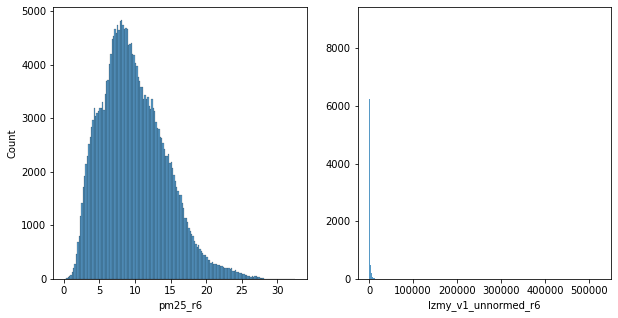

In [23]:
#columns = ['pm25', 'avg_wind_alignment_cosine']
columns = [target_name_s1, predictor_name_s1]


# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    
    if idx in [0]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

``health outcomes``

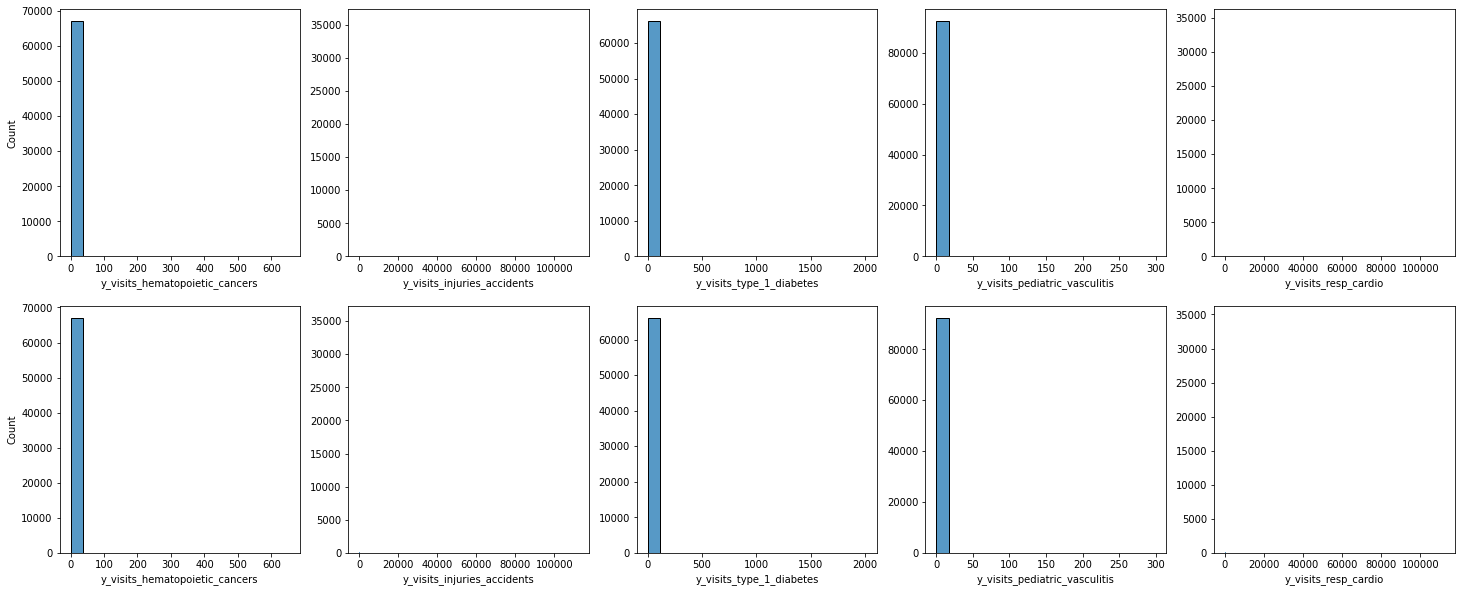

In [24]:
#columns = df_h.columns[1:]
columns = ['y_visits_hematopoietic_cancers', 'y_visits_injuries_accidents', 'y_visits_type_1_diabetes', 'y_visits_pediatric_vasculitis', 'y_visits_resp_cardio'] * 2

# compute visits by patzip_year_month
fig, axes = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(25, 10)) #12

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    if idx in [0, 5]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

---
### Step 7: Analysis - linear modeling

#### 7.1.

In [25]:
# create a list of columns for outcome variables with health outcome lag window added
y_col_names_lag = []
for i in y_col_names:
    new_name = i + HO_lag_input
    y_col_names_lag.append(new_name)
print(y_col_names_lag)


['y_visits_hematopoietic_cancers_fwd3', 'y_visits_injuries_accidents_fwd3', 'y_visits_type_1_diabetes_fwd3', 'y_visits_pediatric_vasculitis_fwd3', 'y_visits_resp_cardio_fwd3']


#### 7.2. ``fit ols``

In [26]:
for col in y_col_names_lag:
    #fit_ols(df_all, col)
    fit_ols(df_all_iv_filtered, col, target_name_s1)

Outcome:  y_visits_hematopoietic_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6,-0.077201,0.032755,-0.143060,-0.011343,2.255405e-02
1,Intercept,2.962980,0.358810,2.241544,3.684416,9.005133e-11


Outcome:  y_visits_injuries_accidents_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6,-18.838090,3.486154,-25.836837,-11.839343,0.000002
1,Intercept,205.183878,40.456170,123.964728,286.403028,0.000006


Outcome:  y_visits_type_1_diabetes_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6,-0.090820,0.020902,-0.132847,-0.048793,0.000072
1,Intercept,0.237203,0.250109,-0.265676,0.740081,0.347678


Outcome:  y_visits_pediatric_vasculitis_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6,-0.003501,0.008666,-0.020945,0.013942,0.688073
1,Intercept,0.526733,0.105110,0.315157,0.738309,0.000008


Outcome:  y_visits_resp_cardio_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6,-20.834868,3.279354,-27.418445,-14.251291,5.711461e-08
1,Intercept,276.941146,38.099647,200.452912,353.429379,2.047717e-09


#### 7.3. ``fit first stage``

In [27]:
#df_all = fit_1st_stage(df_all, 'pm25', 'avg_wind_alignment_cosine')
df_all_iv_filtered = fit_1st_stage(df_all_iv_filtered, target_name_s1, predictor_name_s1, fixed_effects)


Outcome:  pm25_r6
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,Izmy_v1_unnormed_r6,-0.000014,0.000009,-0.000032,0.000004,1.194870e-01
1,Intercept,12.207014,0.017638,12.171694,12.242334,1.494868e-113


#### 7.4. Save stage 1 dataset (csv + parquet)

In [28]:
# Drops all health-data-related columns before saving
saved_stage1 = df_all_iv_filtered.drop(columns=[i for i in df_all_iv_filtered.columns if 'visit' in i])

In [29]:
# Check that tehre are no longer any health-data-related columns in the dataset (should return empty list)
[i for i in saved_stage1.columns if 'visit' in i]

[]

In [44]:
# Saving out datasets
saved_stage1_name = "s1_PREDICTOR_" + predictor_name_s1 + "_TARGETING_" + target_name_s1 + "_LAG_" + HO_lag_input
saved_stage1.to_csv(os.path.join(out_dir1, saved_stage1_name + ".csv"))
saved_stage1.to_parquet(os.path.join(out_dir1, saved_stage1_name + ".parquet"))

#### 7.5. Generate dataset with name of file and corresponding fixed effects (csv)

In [42]:
notebook_number = "1_"
dataset_name_FE = 'stage1_fixed_effects_' + notebook_number + '.csv'
FE_df_data = [[saved_stage1_name+'.csv', fixed_effects]]
FE_df = pd.DataFrame(data=FE_df_data, columns=['filename', 'fixed_effects_list'])
FE_df.to_csv(dataset_name_FE)

#### 7.5.5 Testing Loading Saved Models

In [33]:
from statsmodels.regression.linear_model import OLSResults
new_results = OLSResults.load(os.path.join(out_dir1, "s1_PREDICTOR_Izmy_v1_unnormed_r6_TARGETING_pm25_r6.pkl"))
display(pd.concat(
        [
            
            #fitted.pvalues.values
            pd.DataFrame(new_results.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(new_results.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            new_results.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(new_results.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
        ))

,variable,coef,std err,[0.025,0.975],p-value
0,Izmy_v1_unnormed_r6,-0.000014,0.000009,-0.000032,0.000004,1.194870e-01
1,Intercept,12.207014,0.017638,12.171694,12.242334,1.494868e-113


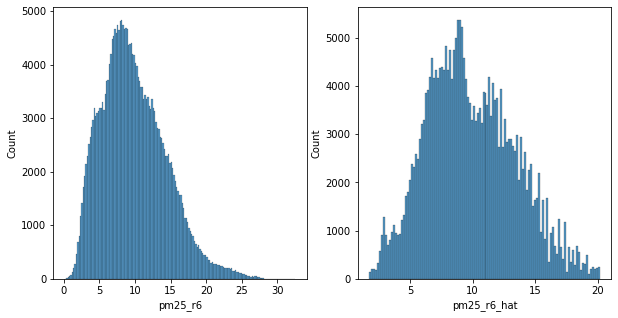

In [34]:
columns = [target_name_s1, target_name_s1+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )

#### 7.6. Stage 1 F-test:

Run an F test with our instrument to study the impact on the pm2.5. 

In [35]:
# get data into right model form
# y, X_null = dmatrices('pm25 ~ 1', data=df_all, return_type='dataframe')
# y, X_instrument = dmatrices('pm25 ~ 1 + avg_wind_alignment_cosine', data=df_all, return_type='dataframe')

y, X_null = dmatrices(f'{target_name_s1} ~ 1', data=df_all_iv_filtered, return_type='dataframe')
y, X_instrument = dmatrices(f'{target_name_s1} ~ 1 + {predictor_name_s1}', data=df_all_iv_filtered, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,262527.0,5.410170e+06,0.0,NaN,NaN,NaN
1,262526.0,5.400968e+06,1.0,9201.72423,447.270165,3.429400e-99


``fit 2sls``

In [37]:
for col in y_col_names_lag:
    fit_2sls(df_all_iv_filtered, col, target_name_s1+"_hat", fixed_effects)

Outcome:  y_visits_hematopoietic_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6_hat,2.383409,1.555149,-0.743427,5.510245,0.131941
1,Intercept,-26.926656,18.950861,-65.029917,11.176604,0.161819


Outcome:  y_visits_injuries_accidents_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6_hat,54.644377,400.185345,-748.761225,858.049979,0.891926
1,Intercept,-679.090570,4874.941707,-10465.944411,9107.763271,0.889760


Outcome:  y_visits_type_1_diabetes_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6_hat,3.327297,3.439119,-3.587516,10.242109,0.338151
1,Intercept,-41.403359,41.916758,-125.682649,42.875932,0.328227


Outcome:  y_visits_pediatric_vasculitis_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6_hat,0.043101,0.901961,-1.772451,1.858654,0.962094
1,Intercept,-0.041254,10.997334,-22.177738,22.095231,0.997023


Outcome:  y_visits_resp_cardio_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6_hat,-95.672809,300.754936,-699.463537,508.117920,0.751701
1,Intercept,1200.318943,3663.645364,-6154.756022,8555.393907,0.744533


In [38]:
from statsmodels.regression.linear_model import OLSResults
new_results2 = OLSResults.load(os.path.join(out_dir2, "s2_PREDICTOR_pm25_r6_hat_TARGETING_y_visits_hematopoietic_cancers_fwd3.pkl"))
display(pd.concat(
        [
            
            #fitted.pvalues.values
            pd.DataFrame(new_results2.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(new_results2.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            new_results2.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(new_results2.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
        ))

,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6_hat,2.383409,1.555149,-0.743427,5.510245,0.131941
1,Intercept,-26.926656,18.950861,-65.029917,11.176604,0.161819


In [39]:
new_results2 = OLSResults.load(os.path.join(out_dir2, "s2_PREDICTOR_pm25_r6_hat_TARGETING_y_visits_injuries_accidents_fwd3.pkl"))
display(pd.concat(
        [
            
            #fitted.pvalues.values
            pd.DataFrame(new_results2.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(new_results2.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            new_results2.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(new_results2.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
        ))

,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r6_hat,54.644377,400.185345,-748.761225,858.049979,0.891926
1,Intercept,-679.090570,4874.941707,-10465.944411,9107.763271,0.889760


In [ ]:
# saved_stage1 is left
# y_whatever is right
# join on school_zip, year_month